# Text Classification - Movie Genre Analysis

- identify the genres of the movies by its titles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import spacy
nlp = spacy.load('en_core_web_sm')

from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /Users/hytung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/hytung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load the data
df = pd.read_csv('movies.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [3]:
print(df.shape)
print(df.info())

(7668, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB
None


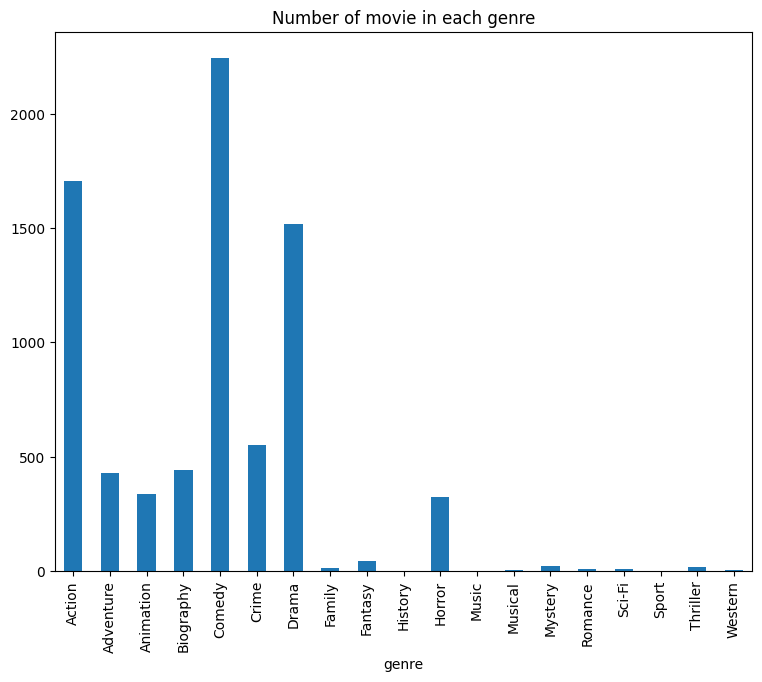

In [4]:
#EDA
genre_plt = df.genre.value_counts().sort_index().plot(kind='bar', title='Number of movie in each genre', figsize=(9,7))
plt.show()

In [5]:
df.genre.value_counts()

genre
Comedy       2245
Action       1705
Drama        1518
Crime         551
Biography     443
Adventure     427
Animation     338
Horror        322
Fantasy        44
Mystery        20
Thriller       16
Family         11
Sci-Fi         10
Romance        10
Western         3
Musical         2
Music           1
History         1
Sport           1
Name: count, dtype: int64

In [6]:
# data cleaning
col_drop = df.iloc[:,[3,4,5,6,7,9,10,11,12,14]]
df.drop(columns=col_drop, inplace=True)
df = df.drop(df[df['genre'].isin(['Family', 'Fantasy', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'History', 'Music', 'Musical', 'Sport', 'Western'])].index)
df.dropna(inplace=True)
df

,name,rating,genre,writer,company
0,The Shining,R,Drama,Stephen King,Warner Bros.
1,The Blue Lagoon,R,Adventure,Henry De Vere Stacpoole,Columbia Pictures
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,Leigh Brackett,Lucasfilm
3,Airplane!,PG,Comedy,Jim Abrahams,Paramount Pictures
4,Caddyshack,R,Comedy,Brian Doyle-Murray,Orion Pictures
...,...,...,...,...,...
7653,The Quarry,R,Crime,Scott Teems,Prowess Pictures
7656,Tulsa,PG-13,Comedy,Scott Pryor,Pryor Entertainment
7658,Black Wall Street Burning,R,Drama,Dekoven Riggins,Notis Studio
7659,I Am Fear,Not Rated,Horror,Kevin Shulman,Roxwell Films


In [7]:
# collect the categorical columns using list comprehension.
categorical_columns = [column for column in df.columns if column in ['rating', 'writer', 'company']]
print(categorical_columns)
# create dictionaries to map the categorical values to numerical values
index_dictionary = dict()
inv_index_dictionary = dict()
for col in categorical_columns:
    unique_values = df[col].unique()
    idx_dict = {val: idx for idx, val in enumerate(unique_values)}        # This dictionary takes the string value and returns a number
    inv_idx_dict = {idx: val for idx, val in enumerate(unique_values)}    # This dictionary takes a number and returns a string value
    # convert the values of the column to number in the dataframe
    df[col] = df[col].map(idx_dict)
    # Store the dictionaries
    index_dictionary[col] = idx_dict
    inv_index_dictionary[col] = inv_idx_dict

print(index_dictionary)
print(inv_index_dictionary)

['rating', 'writer', 'company']
{'rating': {'R': 0, 'PG': 1, 'G': 2, 'Not Rated': 3, 'NC-17': 4, 'Approved': 5, 'TV-PG': 6, 'PG-13': 7, 'Unrated': 8, 'X': 9, 'TV-MA': 10, 'TV-14': 11}, 'writer': {'Stephen King': 0, 'Henry De Vere Stacpoole': 1, 'Leigh Brackett': 2, 'Jim Abrahams': 3, 'Brian Doyle-Murray': 4, 'Victor Miller': 5, 'Dan Aykroyd': 6, 'Jake LaMotta': 7, 'Jerry Siegel': 8, 'Bill Bryden': 9, 'Stanford Sherman': 10, 'Jamie Uys': 11, 'Jules Feiffer': 12, 'Judith Guest': 13, 'Brian De Palma': 14, 'Richard Matheson': 15, 'Christopher Gore': 16, 'Patricia Resnick': 17, 'John Carpenter': 18, 'Bruce Jay Friedman': 19, 'William Friedkin': 20, 'Michael Cimino': 21, 'Thomas Hunter': 22, 'Aaron Latham': 23, 'Paddy Chayefsky': 24, 'Kimi Peck': 25, 'Adam Kennedy': 26, 'W.D. Richter': 27, 'Paul Schrader': 28, 'Alan Ormsby': 29, 'William Gray': 30, 'Hal Needham': 31, 'David Eyre': 32, 'Neil Simon': 33, 'Nancy Meyers': 34, 'Floyd Mutrux': 35, 'Robert Jaffe': 36, 'Samson Raphaelson': 37, 'Thom

In [8]:
len(inv_index_dictionary['writer'])

4426

In [9]:
len(inv_index_dictionary['company'])

2315

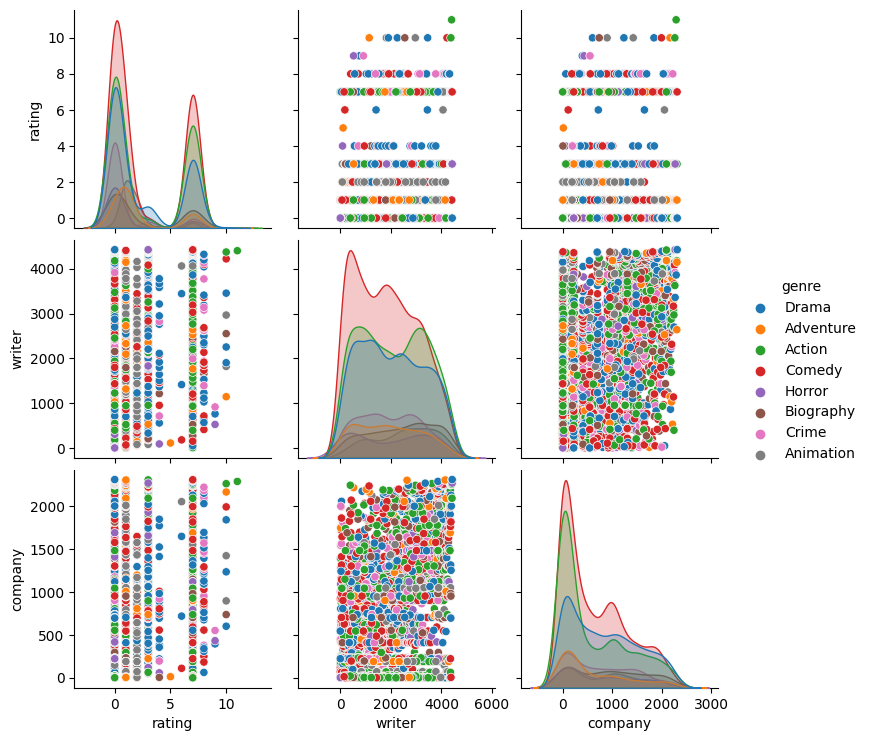

In [10]:
#EDA
sns.pairplot(data=df, hue='genre')

In [11]:
# NLP
# Change all the text to lower case. 
df['name'] = [name.lower() for name in df['name']]

# Tokenization and Remove Stop words, Word Lemmatization
#nltk

lemmatizer = WordNetLemmatizer()
for index, entry in enumerate(df['name']):
    tokens = [lemmatizer.lemmatize(token) for token in nltk.word_tokenize(entry) if ((str(token) not in stopwords.words('english')))]
    df.loc[index, 'clean_name'] = " ".join(tokens)

#spaCy
'''
stop_words = list(STOP_WORDS)
for index, entry in enumerate(df['name']):
    tokens = [token.lemma_ for token in nlp(entry) if ((str(token) not in stop_words) and (token.is_alpha == True))]
    df.loc[index,'clean_name'] = " ".join(tokens)
'''
df

,name,rating,genre,writer,company,clean_name
0,the shining,0.0,Drama,0.0,0.0,shining
1,the blue lagoon,0.0,Adventure,1.0,1.0,blue lagoon
2,star wars: episode v - the empire strikes back,1.0,Action,2.0,2.0,star war : episode v - empire strike back
3,airplane!,1.0,Comedy,3.0,3.0,airplane !
4,caddyshack,0.0,Comedy,4.0,4.0,caddyshack
...,...,...,...,...,...,...
6983,NaN,NaN,NaN,NaN,NaN,space u
7072,NaN,NaN,NaN,NaN,NaN,bye bye man
7186,NaN,NaN,NaN,NaN,NaN,alpha
7274,NaN,NaN,NaN,NaN,NaN,avenger : endgame


In [12]:
df.dropna(inplace=True)
df['genre'] = df['genre'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7293 entries, 0 to 7463
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   name        7293 non-null   object  
 1   rating      7293 non-null   float64 
 2   genre       7293 non-null   category
 3   writer      7293 non-null   float64 
 4   company     7293 non-null   float64 
 5   clean_name  7293 non-null   object  
dtypes: category(1), float64(3), object(2)
memory usage: 349.3+ KB


In [13]:
from wordcloud import WordCloud

In [14]:
comedy = df[df["genre"] == "Comedy"]["clean_name"]
drama = df[df["genre"] == "Drama"]["clean_name"]


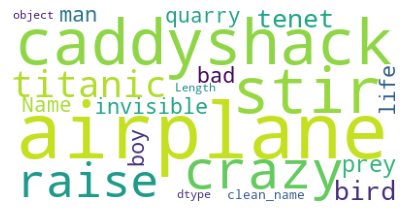

In [15]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="white").generate(str(comedy))
plt.figure(figsize=(5,4))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

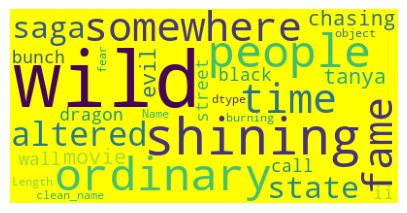

In [16]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="yellow").generate(str(drama))
plt.figure(figsize=(5,4))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
# Perform the train test split on the data and then build the model
train_X, test_X, train_y, test_y = train_test_split(df['clean_name'], df['genre'], 
                                                    stratify = df['genre'],
                                                    test_size=0.3, random_state=42)

In [18]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(5105,)
(2188,)
(5105,)
(2188,)


In [19]:
# Calculate TF-TDF
####  Term Frequency: This summarizes how often a given word appears within a document
#### Inverse Document Frequency: This down scales words that appear a lot across documents

In [20]:
Tfidf_vect = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.8)

Tfidf_vect.fit(train_X)

train_X_Tfidf = Tfidf_vect.transform(train_X)
test_X_Tfidf = Tfidf_vect.transform(test_X)

In [21]:
print(train_X_Tfidf.shape)

(5105, 4330)


In [22]:
print(train_X_Tfidf[0])

  (0, 4021)	1.0


In [23]:
# Coverting to dense matrix and putting in a dataframe to view the Tfidf matrix
dense_mat = train_X_Tfidf.todense()
tfidf_Mat = pd.DataFrame(dense_mat, columns=Tfidf_vect.get_feature_names_out())
tfidf_Mat.head()

,03,10,1000,1001,102,12,123,127,13,13th,...,zombieland,zone,zoo,zookeeper,zoolander,zoom,zoot,zorro,æon,ça
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
print([col for col in tfidf_Mat.columns])

['03', '10', '1000', '1001', '102', '12', '123', '127', '13', '13th', '1492', '15', '1600', '17', '18', '182', '19', '1900', '1917', '1984', '1999', '200', '2000', '2010', '2012', '2046', '2049', '21', '22', '23', '24', '27', '28', '29th', '2½', '30', '300', '3000', '31st', '33', '360', '39', '3d', '3dd', '3rd', '40', '45', '46', '47', '48', '500', '5000', '51', '52', '54', '571', '5th', '60', '6th', '71', '80', '84', '84c', '88', '8mm', '911', '93', '99', '9½', 'abandon', 'abbey', 'abbotts', 'abc', 'abiding', 'abominable', 'abraham', 'absence', 'absolute', 'abyss', 'academia', 'academy', 'acceptable', 'accepted', 'accidental', 'according', 'accountant', 'accused', 'ace', 'acid', 'acre', 'across', 'act', 'action', 'activity', 'ad', 'adaline', 'adam', 'adaptation', 'addams', 'addicted', 'addiction', 'adjuster', 'ado', 'adore', 'adrift', 'adult', 'adventure', 'adventureland', 'advertising', 'affair', 'affliction', 'africa', 'aftermath', 'afternoon', 'age', 'agenda', 'agent', 'agua', 'ahe

In [25]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(train_X_Tfidf, train_y)

# predict the labels on train dataset
pred_train = Naive.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test = Naive.predict(test_X_Tfidf)

# Use classification_report function to get the accuracy
report = classification_report(test_y, pred_test)
print(report)

              precision    recall  f1-score   support

      Action       0.27      0.17      0.21       493
   Adventure       0.00      0.00      0.00       123
   Animation       0.00      0.00      0.00        95
   Biography       0.00      0.00      0.00       129
      Comedy       0.31      0.76      0.44       660
       Crime       0.00      0.00      0.00       162
       Drama       0.20      0.11      0.14       433
      Horror       0.00      0.00      0.00        93

    accuracy                           0.29      2188
   macro avg       0.10      0.13      0.10      2188
weighted avg       0.19      0.29      0.21      2188



In [26]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='linear')
SVM.fit(train_X_Tfidf,train_y)

# predict the labels on train dataset
pred_train1 = SVM.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test1 = SVM.predict(test_X_Tfidf)

# Use classification_report function to get the accuracy
report = classification_report(test_y, pred_test1)
print(report)

              precision    recall  f1-score   support

      Action       0.25      0.19      0.21       493
   Adventure       0.11      0.01      0.02       123
   Animation       0.00      0.00      0.00        95
   Biography       0.00      0.00      0.00       129
      Comedy       0.31      0.70      0.43       660
       Crime       0.00      0.00      0.00       162
       Drama       0.20      0.14      0.16       433
      Horror       0.00      0.00      0.00        93

    accuracy                           0.28      2188
   macro avg       0.11      0.13      0.10      2188
weighted avg       0.20      0.28      0.21      2188



In [27]:
'''
__Observation__: 

    Recall is the performance metric in this case. 
    Based on the Recall score, SVM performed better than Naive Bayes
'''

'\n__Observation__: \n\n    Recall is the performance metric in this case. \n    Based on the Recall score, SVM performed better than Naive Bayes\n'